In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from IPython.display import display

# Read data

In [2]:
af = 'vv'

In [3]:
""" Load original data """
df__test = pd.read_csv(f'data/t.{af}1.csv', index_col=[0])
df__test.head()

,StreamID,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,...,Proto_arp,Proto_other,Service,Service_80,Service_443,Service_21,Service_22,Service_25,Service_6667,Service_other
0,1,2021-08-12 20:56:02.042618,0.248864,udp,150.35.87.62,59827,<->,150.35.83.12,53,CON,...,0.0,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,2021-08-12 20:56:02.051273,0.000458,udp,216.149.170.165,15135,<->,150.35.87.232,13365,CON,...,0.0,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,2021-08-12 20:56:02.056605,0.140449,tcp,81.114.119.142,3577,->,150.35.87.133,80,alltcp,...,0.0,0.0,80,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2021-08-12 20:56:02.108284,0.000666,udp,150.35.87.141,55454,<->,150.35.83.12,53,CON,...,0.0,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,2021-08-12 20:56:02.108367,0.000749,udp,150.35.87.141,51411,<->,150.35.83.12,53,CON,...,0.0,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
""" Load preprocessed data used for feeding the model """
pf = '__1__'
expname = 'exp04_play'
ra = '81.91'
model_name = 'iforest'

# X_train = np.load(f'result/{af}5.{pf}.{model_name}.{expname}.__{ra}__.data.tr.X.npy')
# y_train = np.load(f'data/{af}3.tr.y.npy')

X_test = np.load(f'result/{af}5.{pf}.{model_name}.{expname}.__{ra}__.data.t.X.npy')
y_test = np.load(f'data/{af}3.t.y.npy')

# X_val = np.load(f'result/{af}3-5.{pf}.{model_name}.{expname}.__{ra}__.data.v.X.npy')
# y_val = np.load(f'data/{af}3-3.v.y.npy')

In [5]:
""" Load model """
model = pickle.load(open(f'result/{af}5.{pf}.{model_name}.{expname}.__{ra}__.model.pkl', 'rb'))
#? model config
model_config = open(f'result/{af}5.{pf}.{model_name}.{expname}.__{ra}__.config.txt').read()

In [6]:
""" Load features names """
fts_names = [line.strip() for line in open(f'result/{af}5.{pf}.{model_name}.{expname}.__{ra}__.fts.txt').readlines()]

In [7]:
# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)
# X_test

# Use saved model

In [8]:
# model.decision_function(X_test)
y_pred = model.predict(X_test)

In [9]:
#? relabel to use classification metrics
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# Evaluate model

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay, roc_auc_score

def evaluate(y_true, y_pred, plot_roc=False):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print(classification_report(y_true, y_pred, digits=4))
    roc_auc = roc_auc_score(y_true, y_pred)
    print(roc_auc)

    if plot_roc:
        display = PrecisionRecallDisplay.from_predictions(y_true, y_pred, name=model_name)
        _ = display.ax_.set_title('2-class Precision-Recall curve')

In [11]:
evaluate(y_test, y_pred)

[[752410   9170]
 [  1036   1926]]
              precision    recall  f1-score   support

           0     0.9986    0.9880    0.9933    761580
           1     0.1736    0.6502    0.2740      2962

    accuracy                         0.9867    764542
   macro avg     0.5861    0.8191    0.6336    764542
weighted avg     0.9954    0.9867    0.9905    764542

0.8190977847166908


In [12]:
df_pred = pd.DataFrame(y_pred, columns=[f'Label_{model_name}'])
dfn = pd.concat([df__test.reset_index(), df_pred], axis=1).drop(columns=['index'])
dfn.head()

,StreamID,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,...,Proto_other,Service,Service_80,Service_443,Service_21,Service_22,Service_25,Service_6667,Service_other,Label_iforest
0,1,2021-08-12 20:56:02.042618,0.248864,udp,150.35.87.62,59827,<->,150.35.83.12,53,CON,...,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,2,2021-08-12 20:56:02.051273,0.000458,udp,216.149.170.165,15135,<->,150.35.87.232,13365,CON,...,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,3,2021-08-12 20:56:02.056605,0.140449,tcp,81.114.119.142,3577,->,150.35.87.133,80,alltcp,...,0.0,80,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4,2021-08-12 20:56:02.108284,0.000666,udp,150.35.87.141,55454,<->,150.35.83.12,53,CON,...,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,5,2021-08-12 20:56:02.108367,0.000749,udp,150.35.87.141,51411,<->,150.35.83.12,53,CON,...,0.0,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


## Checking score

In [13]:
#? use the model to score the samples
y_score = model.score_samples(X_test)

In [14]:
df_score = pd.DataFrame(y_score, columns=[f'Score_{model_name}'])
dfn = pd.concat([dfn, df_score], axis=1)

dfn.head()

,StreamID,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,...,Service,Service_80,Service_443,Service_21,Service_22,Service_25,Service_6667,Service_other,Label_iforest,Score_iforest
0,1,2021-08-12 20:56:02.042618,0.248864,udp,150.35.87.62,59827,<->,150.35.83.12,53,CON,...,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,-0.329260
1,2,2021-08-12 20:56:02.051273,0.000458,udp,216.149.170.165,15135,<->,150.35.87.232,13365,CON,...,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,-0.330604
2,3,2021-08-12 20:56:02.056605,0.140449,tcp,81.114.119.142,3577,->,150.35.87.133,80,alltcp,...,80,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.356895
3,4,2021-08-12 20:56:02.108284,0.000666,udp,150.35.87.141,55454,<->,150.35.83.12,53,CON,...,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,-0.314296
4,5,2021-08-12 20:56:02.108367,0.000749,udp,150.35.87.141,51411,<->,150.35.83.12,53,CON,...,other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,-0.312009


In [15]:
dfn[dfn[f'Label_{model_name}'] == 1][['StreamID','StartTime','Label',f'Label_{model_name}']].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.detected.csv')

### Describe

In [16]:
print(dfn.loc[(dfn[f'Label_{model_name}'] == 1)][f'Score_{model_name}'].value_counts(), '\n')
print(dfn.loc[(dfn[f'Label_{model_name}'] == 1)][f'Score_{model_name}'].describe(), '\n')

-0.473040    389
-0.495118    196
-0.470613    113
-0.467518     91
-0.653373     41
            ... 
-0.474972      1
-0.478805      1
-0.483379      1
-0.466628      1
-0.502619      1
Name: Score_iforest, Length: 7755, dtype: int64 

count    11096.000000
mean        -0.524650
std          0.060798
min         -0.765988
25%         -0.566118
50%         -0.496989
75%         -0.475060
max         -0.464703
Name: Score_iforest, dtype: float64 



In [17]:
#? true normal scores
print(dfn.loc[(dfn['Label'] != 5) & (dfn[f'Label_{model_name}'] == 0)][f'Score_{model_name}'].value_counts(), '\n')
print(dfn.loc[(dfn['Label'] != 5) & (dfn[f'Label_{model_name}'] == 0)][f'Score_{model_name}'].describe(), '\n')

-0.311085    3428
-0.311441    3149
-0.311626    3110
-0.316132    3054
-0.312745    2897
             ... 
-0.340814       1
-0.415229       1
-0.324897       1
-0.340646       1
-0.414406       1
Name: Score_iforest, Length: 124441, dtype: int64 

count    752410.000000
mean         -0.339238
std           0.032884
min          -0.464701
25%          -0.356757
50%          -0.323950
75%          -0.313865
max          -0.310354
Name: Score_iforest, dtype: float64 



In [18]:
# #? false alarm scores
# print(dfn.loc[(dfn['Label'] != 5) & (dfn[f'Label_{model_name}'] == 1)][f'Score_{model_name}'].value_counts(), '\n')
# print(dfn.loc[(dfn['Label'] != 5) & (dfn[f'Label_{model_name}'] == 1)][f'Score_{model_name}'].describe(), '\n')

In [19]:
#? true detected scores
print(dfn.loc[(dfn['Label'] == 5) & (dfn[f'Label_{model_name}'] == 1)][f'Score_{model_name}'].value_counts(), '\n')
print(dfn.loc[(dfn['Label'] == 5) & (dfn[f'Label_{model_name}'] == 1)][f'Score_{model_name}'].describe(), '\n')

-0.653373    41
-0.651970    37
-0.648786    36
-0.635999    33
-0.655341    30
             ..
-0.606535     1
-0.638273     1
-0.465388     1
-0.609119     1
-0.485490     1
Name: Score_iforest, Length: 598, dtype: int64 

count    1926.000000
mean       -0.615474
std         0.047183
min        -0.718684
25%        -0.644749
50%        -0.622359
75%        -0.603962
max        -0.464727
Name: Score_iforest, dtype: float64 



In [20]:
# dfn.loc[(dfn['Label'] == 5) & (dfn[f'Label_{model_name}'] == 1)]

## Apply thresh

In [21]:
def evaluate_thresh(score, p=2, plot_roc=False):
    print('\n------------')
    print('p =', p)

    #? check the score for p% of outliers
    score_threshold = np.percentile(score, p)
    
    print('score_threshold', score_threshold)

    #? check the model performance at p% threshold
    y_pred_1 = [1 if i < score_threshold else 0 for i in score]

    #? check the prediction performance
    evaluate(y_test, y_pred_1, plot_roc)

    return y_pred_1

### No thresh

[[752410   9170]
 [  1036   1926]]
              precision    recall  f1-score   support

           0     0.9986    0.9880    0.9933    761580
           1     0.1736    0.6502    0.2740      2962

    accuracy                         0.9867    764542
   macro avg     0.5861    0.8191    0.6336    764542
weighted avg     0.9954    0.9867    0.9905    764542

0.8190977847166908


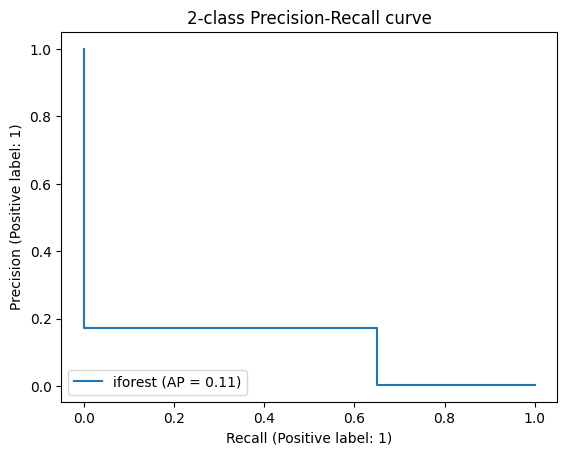

In [22]:
evaluate(y_test, y_pred, plot_roc=True)

dfn[dfn[f'Label_{model_name}'] == 1]['StreamID'].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.detected.__p=None__.csv', index=False)

### p = 2%


------------
p = 2
score_threshold -0.44918330550413654
[[748355  13225]
 [   896   2066]]
              precision    recall  f1-score   support

           0     0.9988    0.9826    0.9907    761580
           1     0.1351    0.6975    0.2264      2962

    accuracy                         0.9815    764542
   macro avg     0.5670    0.8401    0.6085    764542
weighted avg     0.9955    0.9815    0.9877    764542

0.8400682368129841


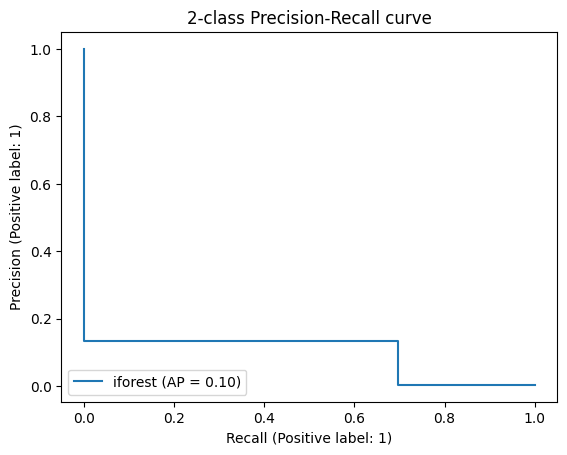

In [23]:
y_thresh_200 = evaluate_thresh(y_score, 2, plot_roc=True)

dfn[f'Label_{model_name}_thresh_2.0'] = pd.Series(y_thresh_200)
dfn[dfn[f'Label_{model_name}_thresh_2.0'] == 1]['StreamID'].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.detected.__p=2.0__.csv', index=False)

### p = 1%


------------
p = 1
score_threshold -0.4786329317468643
[[755773   5807]
 [  1123   1839]]
              precision    recall  f1-score   support

           0     0.9985    0.9924    0.9954    761580
           1     0.2405    0.6209    0.3467      2962

    accuracy                         0.9909    764542
   macro avg     0.6195    0.8066    0.6711    764542
weighted avg     0.9956    0.9909    0.9929    764542

0.8066196716308125


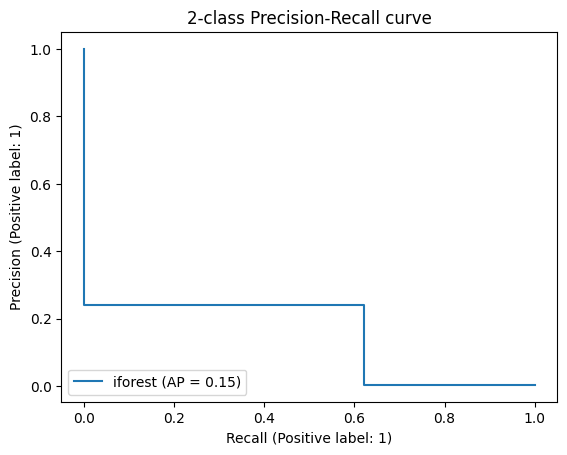

In [24]:
y_thresh_100 = evaluate_thresh(y_score, 1, plot_roc=True)

dfn[f'Label_{model_name}_thresh_1.0'] = pd.Series(y_thresh_100)
dfn[dfn[f'Label_{model_name}_thresh_1.0'] == 1]['StreamID'].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.detected.__p=1.0__.csv', index=False)

### p = 0.5%


------------
p = 0.5
score_threshold -0.5306271793260229
[[759526   2054]
 [  1193   1769]]
              precision    recall  f1-score   support

           0     0.9984    0.9973    0.9979    761580
           1     0.4627    0.5972    0.5214      2962

    accuracy                         0.9958    764542
   macro avg     0.7306    0.7973    0.7597    764542
weighted avg     0.9964    0.9958    0.9960    764542

0.7972672878316746


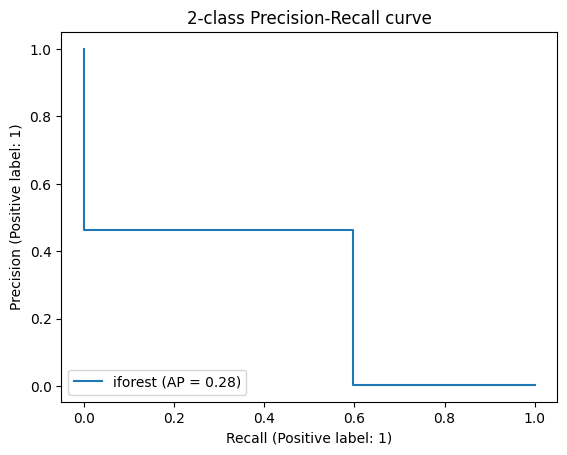

In [25]:
y_thresh_050 = evaluate_thresh(y_score, .5, plot_roc=True)

dfn[f'Label_{model_name}_thresh_0.5'] = pd.Series(y_thresh_050)
dfn[dfn[f'Label_{model_name}_thresh_0.5'] == 1]['StreamID'].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.detected.__p=0.5__.csv', index=False)

Reducing the threshold increases the precision (will recude the recall for class 1)

### p = 0.45%


------------
p = 0.45
score_threshold -0.5422179920372868
[[759902   1678]
 [  1199   1763]]
              precision    recall  f1-score   support

           0     0.9984    0.9978    0.9981    761580
           1     0.5124    0.5952    0.5507      2962

    accuracy                         0.9962    764542
   macro avg     0.7554    0.7965    0.7744    764542
weighted avg     0.9965    0.9962    0.9964    764542

0.796501313884233


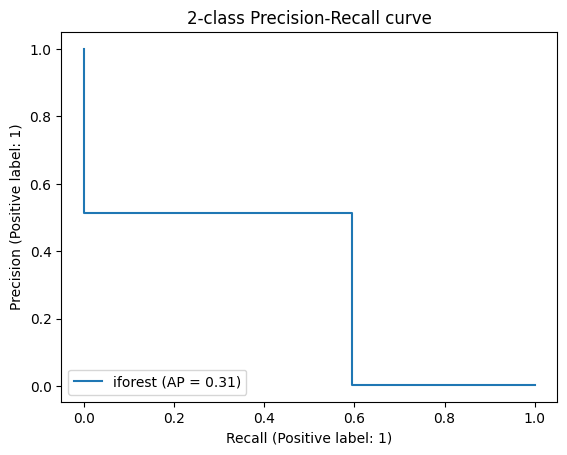

In [26]:
y_thresh_045 = evaluate_thresh(y_score, .45, plot_roc=True)

dfn[f'Label_{model_name}_thresh_0.45'] = pd.Series(y_thresh_045)
dfn[dfn[f'Label_{model_name}_thresh_0.45'] == 1]['StreamID'].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.detected.__p=0.45__.csv', index=False)

### p = 0.4%


------------
p = 0.4
score_threshold -0.5545033574490165
[[760264   1316]
 [  1219   1743]]
              precision    recall  f1-score   support

           0     0.9984    0.9983    0.9983    761580
           1     0.5698    0.5885    0.5790      2962

    accuracy                         0.9967    764542
   macro avg     0.7841    0.7934    0.7887    764542
weighted avg     0.9967    0.9967    0.9967    764542

0.7933628804568291


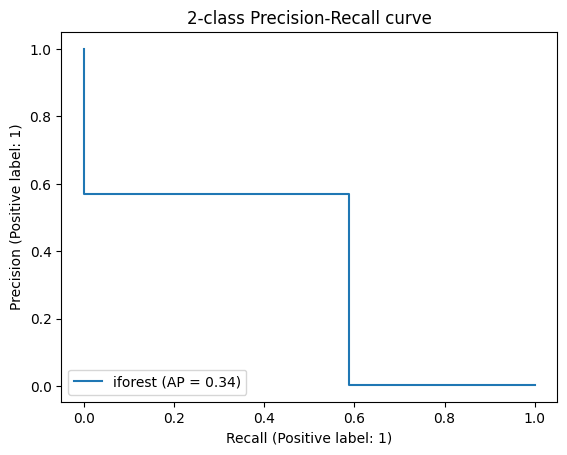

In [27]:
y_thresh_040 = evaluate_thresh(y_score, .4, plot_roc=True)

dfn[f'Label_{model_name}_thresh_0.4'] = pd.Series(y_thresh_040)
dfn[dfn[f'Label_{model_name}_thresh_0.4'] == 1]['StreamID'].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.detected.__p=0.4__.csv', index=False)

In [28]:
dfn[['StreamID','StartTime','Label',f'Label_{model_name}',f'Label_{model_name}_thresh_1.0',f'Label_{model_name}_thresh_0.5',f'Label_{model_name}_thresh_0.45',f'Label_{model_name}_thresh_0.4']].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.dfn.csv')

# Improv

It's a simple post-processing trick.  
By considering the ratio of number of flows detected as bots over the total flows from one SrcAddr, we can observe that if flows classified as bots by the model come from the same SrcAddr will be more likely to be bots (in contrast with only few flows come from an SrcAddr are detected as bots, which could be noise).  

**Note** that using this tactic will require analysing detected batch after a certain time period. It will decrease the capability to detect early anomalies.  

In [29]:
pred_field = f'Label_{model_name}_thresh_1.0'

In [30]:
detected = dfn.loc[(dfn[pred_field] == 1)]

In [31]:
# print('total 0', len(dfn.loc[(dfn['Label'] == 0)]))
# print('total 1', len(dfn.loc[(dfn['Label'] == 1)]))
# print('total 2', len(dfn.loc[(dfn['Label'] == 2)]))
# print('total 3', len(dfn.loc[(dfn['Label'] == 3)]))
# print('total 4', len(dfn.loc[(dfn['Label'] == 4)]))
# detected['Label'].value_counts()

In [32]:
detected_by_src = detected['SrcAddr'].value_counts()
detected_by_src

150.35.87.168      1839
150.35.87.62        714
150.35.89.99        425
120.105.252.106     341
150.35.99.72        239
                   ... 
196.8.219.103         1
80.240.30.7           1
114.4.136.89          1
215.43.156.4          1
192.12.25.68          1
Name: SrcAddr, Length: 991, dtype: int64

In [33]:
detected['SrcAddr'].describe()

count              7646
unique              991
top       150.35.87.168
freq               1839
Name: SrcAddr, dtype: object

In [34]:
""" consider one SrcAddr, how many flows are detected as bot over total of flows """
counts_by_src = dfn['SrcAddr'].value_counts()
pd_counts_by_src = counts_by_src.to_frame().rename(columns={'SrcAddr': 'n_flows_total'})
pd_detected_by_src = detected_by_src.to_frame().rename(columns= {'SrcAddr': 'n_flows_detected'})

pd_by_src = pd.concat([pd_counts_by_src, pd_detected_by_src], axis=1).fillna(0)
pd_by_src['p'] = pd_by_src['n_flows_detected']/pd_by_src['n_flows_total']
pd_by_src = pd_by_src.sort_values(by=['p', 'n_flows_detected'], ascending=[False, False])

pd_by_src

,n_flows_total,n_flows_detected,p
214.104.40.118,81,81.0,1.0
195.171.88.110,62,62.0,1.0
84.5.198.99,35,35.0,1.0
92.238.40.133,34,34.0,1.0
89.52.119.227,34,34.0,1.0
...,...,...,...
197.75.169.85,1,0.0,0.0
176.22.230.180,1,0.0,0.0
88.230.136.131,1,0.0,0.0
82.55.192.57,1,0.0,0.0


In [35]:
idx_keep = detected_by_src[detected_by_src > 100].index
dfn[f'{pred_field}_improv'] = dfn[pred_field]
dfn.loc[(dfn[pred_field] == 1) & (~dfn['SrcAddr'].isin(idx_keep)), f'{pred_field}_improv'] = 0

In [36]:
y_pred_improv = dfn[f'{pred_field}_improv'].values

In [37]:
#? re-evaluate
evaluate(y_test, y_pred_improv)

[[759172   2408]
 [  1123   1839]]
              precision    recall  f1-score   support

           0     0.9985    0.9968    0.9977    761580
           1     0.4330    0.6209    0.5102      2962

    accuracy                         0.9954    764542
   macro avg     0.7158    0.8089    0.7539    764542
weighted avg     0.9963    0.9954    0.9958    764542

0.8088512165768457


## Improv Pipeline

In [38]:
def improv(pred_field, p='None', num_thresh=100, per_thresh=0.5):
    """
    num_thresh: Only `SrcAddr` that has more than `num_thresh` detected as bot is classified as bot, otherwise consider them as normal.
    per_thresh: Only `SrcAddr` that has n_detected/n_total > per_thresh  detected as bot is classified as bot, otherwise consider them as normal.
    """
    detected = dfn.loc[(dfn[pred_field] == 1)]

    counts_by_src = dfn['SrcAddr'].value_counts()
    detected_by_src = detected['SrcAddr'].value_counts()
    # display(detected_by_src)

    pd_counts_by_src = counts_by_src.to_frame().rename(columns={'SrcAddr': 'n_flows_total'})
    pd_detected_by_src = detected_by_src.to_frame().rename(columns= {'SrcAddr': 'n_flows_detected'})
    
    pd_by_src = pd.concat([pd_counts_by_src, pd_detected_by_src], axis=1).fillna(0)
    pd_by_src['p'] = pd_by_src['n_flows_detected']/pd_by_src['n_flows_total']
    pd_by_src = pd_by_src.sort_values(by=['p', 'n_flows_detected'], ascending=[False, False])
    

    #? debug
    # # display(pd_counts_by_src)
    # # display(pd_detected_by_src)
    # display(pd_by_src)

    # concernAddr = pd_by_src[pd_by_src['p'] > per_thresh].index
    # display(pd_by_src[pd_by_src['p'] > per_thresh])
    # display(detected[detected['SrcAddr'].isin(concernAddr)])

    dfn[f'{pred_field}_improv'] = dfn[pred_field]
    if num_thresh == 0 and per_thresh > 0:
        idx_keep = pd_by_src[pd_by_src['p'] > per_thresh].index
        dfn.loc[(dfn[pred_field] == 1) & (~dfn['SrcAddr'].isin(idx_keep)), f'{pred_field}_improv'] = 0
    elif num_thresh > 0 and per_thresh == 0:
        idx_keep = pd_by_src[pd_by_src['n_flows_detected'] > num_thresh].index
        dfn.loc[(dfn[pred_field] == 1) & (~dfn['SrcAddr'].isin(idx_keep)), f'{pred_field}_improv'] = 0
    elif num_thresh > 0 and per_thresh > 0:
        idx_keep = pd_by_src[(pd_by_src['n_flows_detected'] > num_thresh) & (pd_by_src['p'] > per_thresh)].index
        dfn.loc[(dfn[pred_field] == 1) & (~dfn['SrcAddr'].isin(idx_keep)), f'{pred_field}_improv'] = 0
    
    y_pred_improv = dfn[f'{pred_field}_improv'].values


    #? re-evaluate
    evaluate(y_test, y_pred_improv, plot_roc=True)

    #? save
    dfn[dfn[f'{pred_field}_improv'] == 1]['StreamID'].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.detected.__p={p}__.__improv_{num_thresh}_{per_thresh}__.csv', index=False)
    dfn[dfn[f'{pred_field}_improv'] == 1].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.detected.__p={p}__.__improv_{num_thresh}_{per_thresh}__.full.csv', index=False)

[[760651    929]
 [  1036   1926]]
              precision    recall  f1-score   support

           0     0.9986    0.9988    0.9987    761580
           1     0.6746    0.6502    0.6622      2962

    accuracy                         0.9974    764542
   macro avg     0.8366    0.8245    0.8305    764542
weighted avg     0.9974    0.9974    0.9974    764542

0.8245082471763143


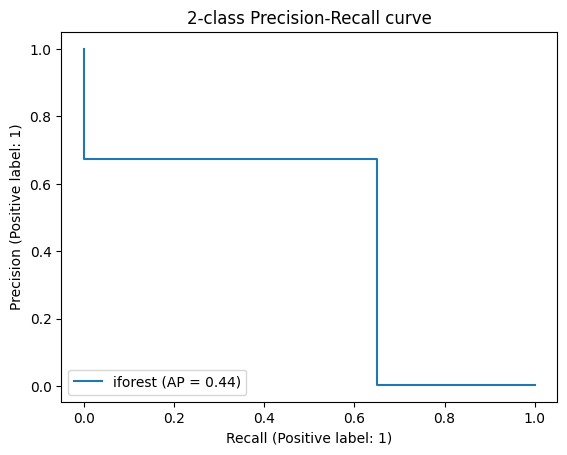

In [39]:
improv(f'Label_{model_name}')

[[759692   1888]
 [   896   2066]]
              precision    recall  f1-score   support

           0     0.9988    0.9975    0.9982    761580
           1     0.5225    0.6975    0.5975      2962

    accuracy                         0.9964    764542
   macro avg     0.7607    0.8475    0.7978    764542
weighted avg     0.9970    0.9964    0.9966    764542

0.8475113156753491


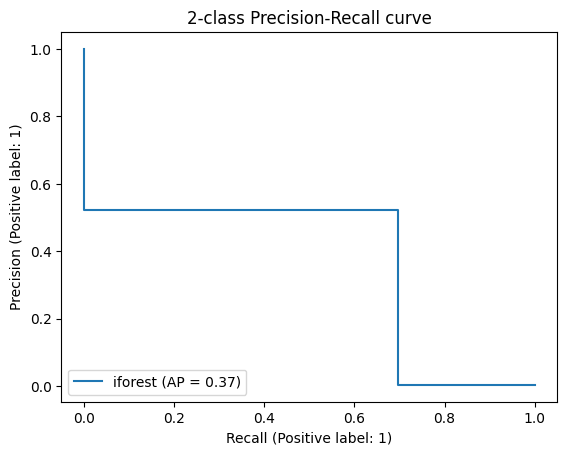

In [40]:
improv(f'Label_{model_name}_thresh_2.0', '2.0')

[[761000    580]
 [  1123   1839]]
              precision    recall  f1-score   support

           0     0.9985    0.9992    0.9989    761580
           1     0.7602    0.6209    0.6835      2962

    accuracy                         0.9978    764542
   macro avg     0.8794    0.8101    0.8412    764542
weighted avg     0.9976    0.9978    0.9977    764542

0.8100513531350536


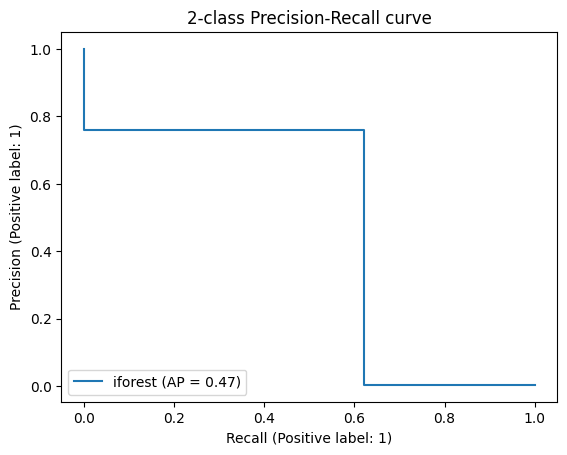

In [41]:
improv(f'Label_{model_name}_thresh_1.0', '1.0')

[[761392    188]
 [  1193   1769]]
              precision    recall  f1-score   support

           0     0.9984    0.9998    0.9991    761580
           1     0.9039    0.5972    0.7193      2962

    accuracy                         0.9982    764542
   macro avg     0.9512    0.7985    0.8592    764542
weighted avg     0.9981    0.9982    0.9980    764542

0.7984923725240246


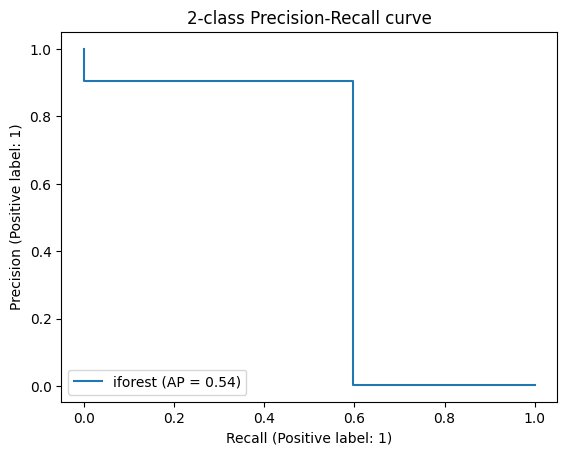

In [42]:
improv(f'Label_{model_name}_thresh_0.5', '0.5')

[[761419    161]
 [  1199   1763]]
              precision    recall  f1-score   support

           0     0.9984    0.9998    0.9991    761580
           1     0.9163    0.5952    0.7217      2962

    accuracy                         0.9982    764542
   macro avg     0.9574    0.7975    0.8604    764542
weighted avg     0.9981    0.9982    0.9980    764542

0.7974972696603825


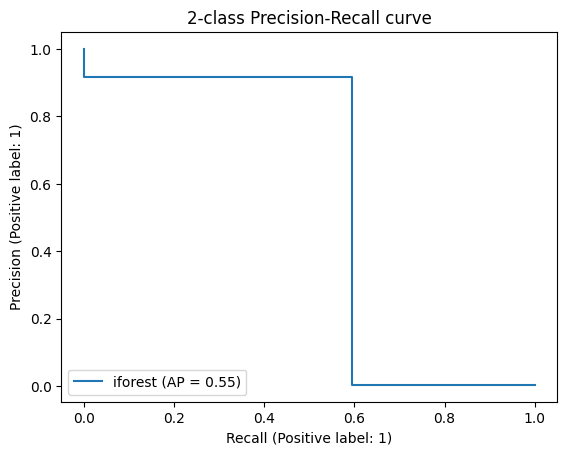

In [43]:
improv(f'Label_{model_name}_thresh_0.45', '0.45')

[[761452    128]
 [  1219   1743]]
              precision    recall  f1-score   support

           0     0.9984    0.9998    0.9991    761580
           1     0.9316    0.5885    0.7213      2962

    accuracy                         0.9982    764542
   macro avg     0.9650    0.7941    0.8602    764542
weighted avg     0.9981    0.9982    0.9980    764542

0.7941428379136951


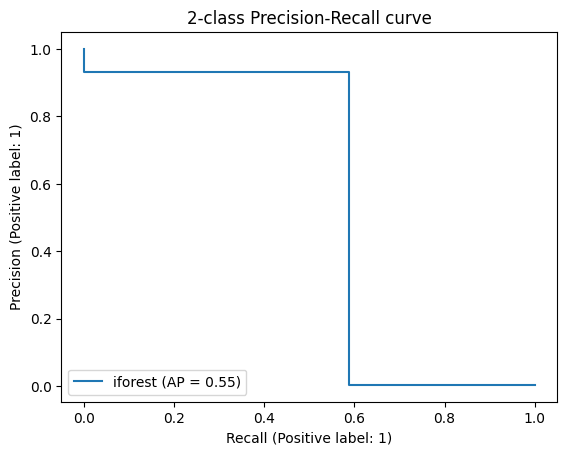

In [44]:
improv(f'Label_{model_name}_thresh_0.4', '0.4')

In [50]:
dfn[dfn['Label'] == 5][['StreamID','StartTime','Proto','State','Dport','LabelStr','Label',f'Label_{model_name}',f'Label_{model_name}_thresh_1.0',f'Label_{model_name}_thresh_0.5',f'Label_{model_name}_thresh_0.45',f'Label_{model_name}_thresh_0.4']].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.bots.csv')

In [51]:
dfn[(dfn['Label'] == 5) & (dfn[f'Label_{model_name}'] == 1)][['StreamID','StartTime','Proto','State','Dport','LabelStr','Label',f'Label_{model_name}',f'Label_{model_name}_thresh_1.0',f'Label_{model_name}_thresh_0.5',f'Label_{model_name}_thresh_0.45',f'Label_{model_name}_thresh_0.4']].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.true_bots.csv')

In [52]:
dfn[(dfn['Label'] == 5) & (dfn[f'Label_{model_name}'] == 0)][['StreamID','StartTime','Proto','State','Dport','LabelStr','Label',f'Label_{model_name}',f'Label_{model_name}_thresh_1.0',f'Label_{model_name}_thresh_0.5',f'Label_{model_name}_thresh_0.45',f'Label_{model_name}_thresh_0.4']].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.missed_bots.csv')

In [49]:
dfn[dfn['Label'] != 5][(dfn[f'Label_{model_name}'] == 1) | (dfn[f'Label_{model_name}_thresh_1.0'] == 1) | (dfn[f'Label_{model_name}_thresh_0.5'] == 1) | (dfn[f'Label_{model_name}_thresh_0.4'] == 1)][['StreamID','StartTime','Proto','State','Dport','LabelStr','Label',f'Label_{model_name}',f'Label_{model_name}_thresh_1.0',f'Label_{model_name}_thresh_0.5',f'Label_{model_name}_thresh_0.45',f'Label_{model_name}_thresh_0.4']].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.false_alarm.csv')

C:\Users\ZEPHYRUS\AppData\Local\Temp\ipykernel_14092\639440608.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfn[dfn['Label'] != 5][(dfn[f'Label_{model_name}'] == 1) | (dfn[f'Label_{model_name}_thresh_1.0'] == 1) | (dfn[f'Label_{model_name}_thresh_0.5'] == 1) | (dfn[f'Label_{model_name}_thresh_0.4'] == 1)][['StreamID','StartTime','Proto','State','Dport','LabelStr','Label',f'Label_{model_name}',f'Label_{model_name}_thresh_1.0',f'Label_{model_name}_thresh_0.5',f'Label_{model_name}_thresh_0.45',f'Label_{model_name}_thresh_0.4']].to_csv(f'result/{af}6.{pf}.{model_name}.{expname}.__{ra}__.false_alarm.csv')


In [53]:
dfn[(dfn['Label'] == 5) & (dfn[f'Label_{model_name}'] == 1)]['LabelStr'].value_counts()

flow=From-Botnet-V45-TCP-Attempt-SPAM                          980
flow=From-Botnet-V45-ICMP                                      812
flow=From-Botnet-V46-TCP-Not-Encrypted-SMTP-Private-Proxy-1    104
flow=From-Botnet-V46-TCP-Attempt                                21
flow=From-Botnet-V46-TCP-Attempt-SPAM                            6
flow=From-Botnet-V45-TCP-CC106-IRC-Not-Encrypted                 2
flow=From-Botnet-V46-TCP-CC1-HTTP-Not-Encrypted                  1
Name: LabelStr, dtype: int64

In [54]:
dfn[(dfn['Label'] == 5) & (dfn[f'Label_{model_name}'] == 0)]['LabelStr'].value_counts()

flow=From-Botnet-V46-TCP-Attempt                                 401
flow=From-Botnet-V45-TCP-Attempt-SPAM                            147
flow=From-Botnet-V46-TCP-Not-Encrypted-SMTP-Private-Proxy-1       77
flow=From-Botnet-V46-UDP-DNS                                      49
flow=From-Botnet-V45-TCP-CC73-Not-Encrypted                       47
flow=From-Botnet-V45-UDP-DNS                                      31
flow=From-Botnet-V45-UDP-Attempt                                  29
flow=From-Botnet-V46-TCP-Established-HTTP-To-Microsoft-6          21
flow=From-Botnet-V46-TCP-Established-SPAM                         19
flow=From-Botnet-V46-TCP-Established-Custom-Encryption-1          17
flow=From-Botnet-V46-TCP-HTTP-Google-Net-Established-2            17
flow=From-Botnet-V46-TCP-Established-SSL-To-Microsoft-6           16
flow=From-Botnet-V46-TCP-Established-HTTP-Ad-46                   13
flow=From-Botnet-V46-TCP-Established-SSL-To-Microsoft-7           13
flow=From-Botnet-V46-TCP-Attempt-S